In [15]:
suppressPackageStartupMessages({
  library(alphahull)
  library(cowplot)
  library(dataorganizer)
  library(EBImage)
  library(ggplot2)
  library(ggrastr)
  library(magrittr)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

ℹ Loading cellAdmixNotebooks


In [2]:
# load data
cell_annot <- prepare_nsclc_metadata(reps='one')
df <- prepare_nsclc_transcript_data(cell_annot,reps='one')
rna_markers <- load_markers_nsclc()
colnames(rna_markers) <- c('Gene','cluster')

base_dir <- CachePath('nsclc_scaled_dat11/')

k_joint <- c(15)
# k_joint <- c(30)
k_ct <- c()

# load the precomputed NMF and CRF results (from NSCLC_nmf_crf_benchmark.R)
nmf_crf <- load_nmf_crf_multi(k_joint, k_ct, dir=base_dir)
all_nmf <- nmf_crf[[1]]
crf_all <- nmf_crf[[2]]

crf_res <- crf_all[['joint_15']]
# crf_res <- crf_all[['joint_30']]


df_for_memb <- df
# converting back to px from um units
df_for_memb$x <- (df_for_memb$x * 1000) / 180
df_for_memb$y <- (df_for_memb$y * 1000) / 180
df_for_memb$z <- (df_for_memb$z * 1000) / 800

df_for_memb <- df_for_memb[,c('x_local_px','y_local_px','z','cell','fov','celltype','gene')]
colnames(df_for_memb) <- c('x','y','z','cell','fov','celltype','gene')

# # remove z slices that we don't have images for
ndx_keep <- which(df_for_memb$z %in% c(0:8))
df_for_memb <- df_for_memb[ndx_keep,]
# also need to subset the CRF results to these same indices

crf_res <- crf_res[ndx_keep,,drop=FALSE]

df_for_memb$factor <- crf_res[,1]

In [ ]:
cells_plot <- c("c_1_26_1715", "c_1_26_2875")
fovs_load <- sapply(cells_plot, \(x) strsplit(x,split='_')[[1]][[3]]) %>% unique()
z_slice <- 4

# load images for the fovs these cells are in
stains_per_fov = fovs_load %>% setNames(., .) %>% lapply(\(fov) {
  z_slice %>% setNames(., .) %>% sccore::plapply(\(z) {
    fid <- ifelse(nchar(fov) == 1, paste0('0', fov), fov)

    paste0("20210907_180607_S1_C902_P99_N99_F0", fid,"_Z00", z, ".TIF") %>%
      DatasetPath('nsclc_lung5_1', 'RawMorphology', .) %>%
      readImage() %>% imageData()
  }, n.cores=6)
})

In [4]:
# purple is dapi, green is membrane
stains_colored_per_fov = lapply(stains_per_fov, lapply, \(stain) {
  list(stain[,,1], stain[,,5]) %>%
    combinedStainImage(palettes=c("Greens","Purples"), clip.min=c(0.5, 0.5), clip.max=c(0.99, 0.975))
  # combinedStainImage(palettes=c("Greens","Purples"), clip.min=c(0.7, 0.7), clip.max=c(0.975, 0.925))
})

colors <- c(malignant="#F8766D", fibroblast="#00BFC4", macrophage="#ec7014", `non-marker`="black")
shape_scales <- c(malignant=24, fibroblast=21, macrophage=23, `non-marker`=22)

cp_theme <- theme_legend(position=c(1, 1), background.alpha=0.6) + theme(
  panel.grid=element_blank(),
  legend.key=element_blank(),
  legend.text=element_text(size=14),
  legend.title=element_text(size=14, face="bold"),
  plot.title=element_text(hjust=0.02, vjust=-7, face = "bold", size=14),
  plot.margin=margin(0.1, 0.1, 0.1, 0.1, unit="in"),
  axis.title=element_blank()
)

Normalizing stains

Creating combined stain image

Adjusting colors by brightness

Combining stains

Done!



In [5]:
gg_cells <- mapply(\(full.id) {
  fov.id = strsplit(full.id, "_")[[1]][3]
  df_cell = df_for_memb[df_for_memb$cell==full.id,]
  df_cell %>% mutate(
    source=ifelse(
      gene %in% rna_markers$Gene[rna_markers$cluster=='malignant'], 'malignant',
      ifelse(
        gene %in% rna_markers$Gene[rna_markers$cluster=='fibroblast'], 'fibroblast',
        'non-marker'
      )
    )
  ) %>%
    mutate(source=factor(source, levels=c('fibroblast', 'malignant', 'non-marker'))) %>%
    plotCellAdmixture(
      stains=stains_colored_per_fov[[fov.id]],
      cell.id=full.id, z.id=4, filter.z=FALSE, expand=0.15,
      color.scale=colors, shape.scale=shape_scales,
      size=3,
      bg.name='non-marker',inv.y.global=TRUE
    ) + cp_theme + ggtitle(paste0("Cell ", full.id))
},
cells_plot,
SIMPLIFY=FALSE
)

tv <- seq(0, 1, 0.01)
leg_gg_base <- ggplot(data.frame(x=tv)) + geom_point(aes(x=x, y=x, color=x)) +
  cp_theme +
  guides(color=guide_colorbar(direction = "horizontal", title.position = "top", barwidth = 11, barheight = 0.75))

lgg1 <- leg_gg_base + scale_color_distiller(palette="Greens", direction=1, name="Membrane")
lgg2 <- leg_gg_base + scale_color_distiller(palette="Purples", direction=1, name="DAPI")


tlg <- guide_legend(direction="horizontal", title.position="top", title="Marker type")
lgg0 <- gg_cells[[1]] + guides(fill=tlg, shape=tlg, size=tlg)

gg_cells2 <- gg_cells %>% lapply(rasterise, layers="Tile") %>% lapply(`+`, theme(legend.position="none")) %>% {plot_grid(plotlist=., ncol=1)}
legends <- lapply(list(lgg0, lgg1, lgg2),function(x) {
  legend <- get_plot_component(x, 'guide-box-inside', return_all = TRUE)
  return(legend)
})

In [6]:
### now plotting transcripts colored by crf factor assignment
# myColors2 <- c(RColorBrewer::brewer.pal(6, 'Set3')[3:6],'grey70')
# myColors2 <- c(RColorBrewer::brewer.pal(10, 'Set3')[c(3,4,7,8)],'grey70')
# myColors2 <- c('turquoise','coral2','steelblue','goldenrod3','grey70')
myColors2 <- c('coral1','cyan2','grey70')
f_lab <- c(7,10)

factor_plots <- lapply(cells_plot,function(full.id){
  fov.id = strsplit(full.id, "_")[[1]][3]
  df.spatial = df_for_memb[df_for_memb$cell==full.id,]

  df.spatial$factor[!(df.spatial$factor %in% f_lab)] <- 'other'
  stains <- stains_colored_per_fov[[fov.id]]
  z.id=4
  filter.z=FALSE
  expand=0.15
  color.scale=myColors2
  shape.scale=NULL
  size=3

  p.df <- extractAdjacentMolecules(df.spatial, cell.id=full.id, offset=.25)

  # Subsetting is required for export, as otherwise it stores the whole image
  xr <- range(p.df$x)
  yr <- range(p.df$y)
  dx <- diff(xr) * expand
  xr <- xr + c(-dx, dx)
  dy <- diff(yr) * expand
  yr <- yr + c(-dy, dy)

  stain <- stains[[paste(z.id)]] %>%
    .[(nrow(.)-yr[2]):(nrow(.)-yr[1]), xr[1]:xr[2]] %>%
    annotation_raster(xmin=xr[1], xmax=xr[2], ymin=yr[1], ymax=yr[2])

  p.df$factor <- as.factor(p.df$factor)
  gg <- plotMolecules(size=1.5,
                      p.df, color="factor", scale.z=FALSE, stain=stain,
                      expand=c(expand, 0)
  )
  gg <- gg +
    scale_colour_manual(breaks = c(10,7,'other'), values = myColors2) +
    labs(colour="Factor") + cp_theme + ggtitle(paste0("Cell ", full.id))
  return(gg)
})


tlg <- guide_legend(direction="horizontal", title.position="top", title="Factor")
lgg3 <- factor_plots[[1]] + guides(color=tlg)
lgg3 <- get_plot_component(lgg3, 'guide-box-inside', return_all = TRUE)
legends[[length(legends)+1]] <- lgg3

factor_plots2 <- factor_plots %>% lapply(rasterise, layers="Tile") %>% lapply(`+`, theme(legend.position="none")) %>% {plot_grid(plotlist=., ncol=1)}

In [7]:
# now plotting the cleaned cells
gg_cells_after <- mapply(\(full.id) {
  fov.id = strsplit(full.id, "_")[[1]][3]
  df_cell = df_for_memb[df_for_memb$cell==full.id,]
  # subset df_cell to only molecules kept after cleaning
  df_cell_cln <- df_cell[df_cell$factor!=10,]
  df_cell_cln %>% mutate(
    source=ifelse(
      gene %in% rna_markers$Gene[rna_markers$cluster=='malignant'], 'malignant',
      ifelse(
        gene %in% rna_markers$Gene[rna_markers$cluster=='fibroblast'], 'fibroblast',
        'non-marker'
      )
    )
  ) %>%
    mutate(source=factor(source, levels=c('fibroblast', 'malignant', 'non-marker'))) %>%
    plotCellAdmixture(
                    stains_colored_per_fov[[fov.id]],
                    cell.id=full.id, z.id=4, filter.z=FALSE, expand=0.15,
                    color.scale=colors, shape.scale=shape_scales,
                    size=3,unclean_cell_for_bounds=df_cell,
                    bg.name='non-marker',inv.y.global=TRUE
  ) + cp_theme + ggtitle(paste0("Cell ", full.id))
},
cells_plot,
SIMPLIFY=FALSE
)

gg_cells_after2 <- gg_cells_after %>% lapply(rasterise, layers="Tile") %>% lapply(`+`, theme(legend.position="none")) %>% {plot_grid(plotlist=., ncol=1)}

legends <- plot_grid(plotlist=legends, nrow=1)

all_cells_plts <- plot_grid(plotlist=list(gg_cells2,factor_plots2,gg_cells_after2), nrow=1)
fig <- plot_grid(plotlist=list(all_cells_plts,legends), nrow=2, rel_heights=c(4.5, 0.75))

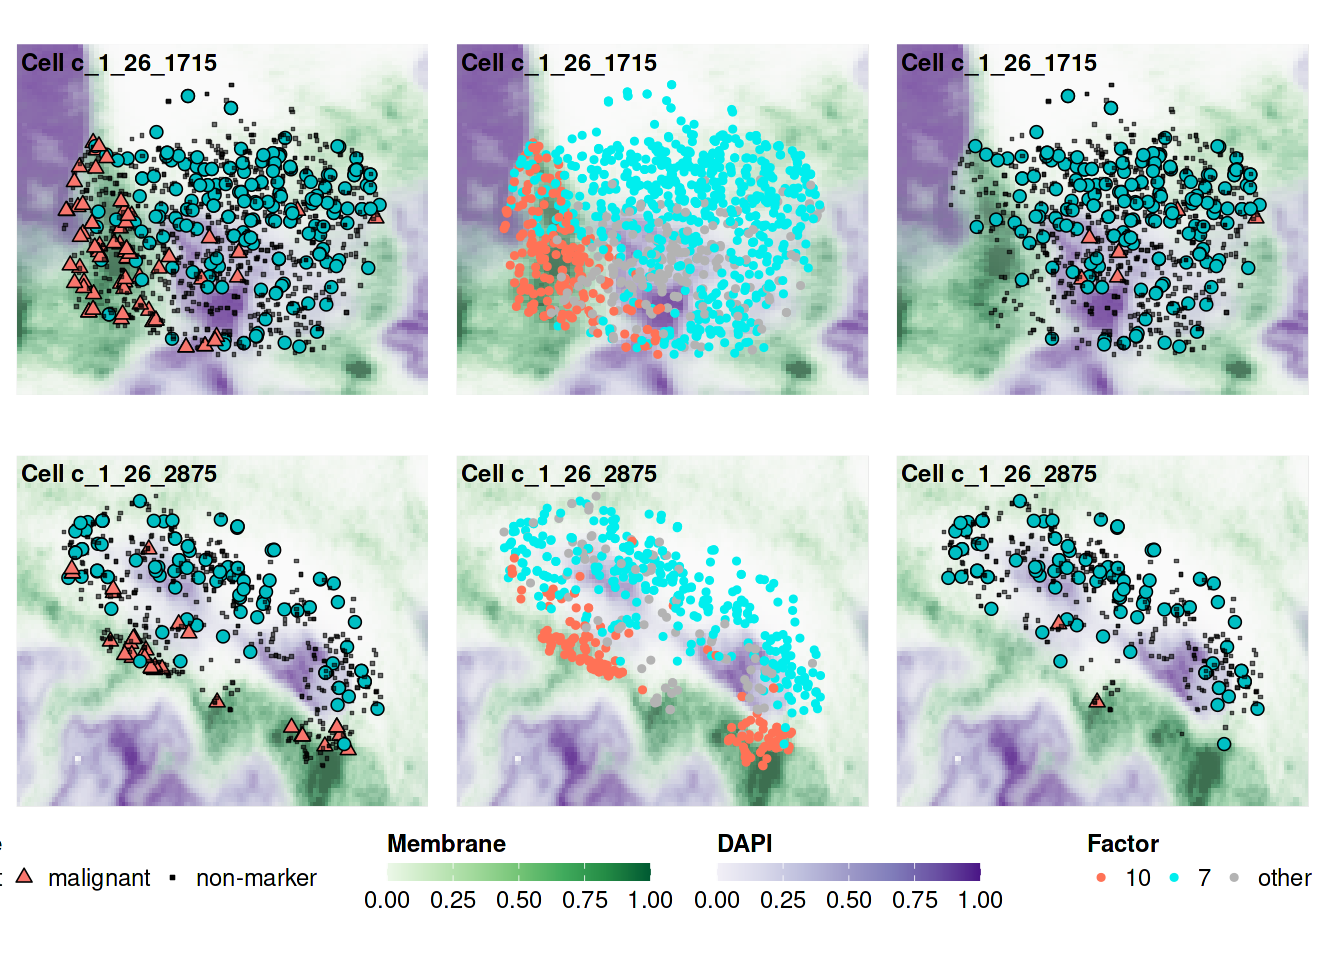

In [8]:
options(repr.plot.width=11, repr.plot.height=8)

fig

In [9]:
pdf(OutputPath("nsclc_example_crf.pdf"), useDingbats=FALSE, width=11, height=8)
fig
dev.off()

png 
  2

In [10]:
# now just plotting cells without factors
cells_plot <- c("c_1_26_535","c_1_26_1715","c_1_26_2875")

gg_cells <- mapply(\(full.id) {
  fov.id = strsplit(full.id, "_")[[1]][3]
  df_cell = df_for_memb[df_for_memb$cell==full.id,]
  df_cell %>% mutate(
    source=ifelse(
      gene %in% rna_markers$Gene[rna_markers$cluster=='malignant'], 'malignant',
      ifelse(
        gene %in% rna_markers$Gene[rna_markers$cluster=='fibroblast'], 'fibroblast',
        'non-marker'
      )
    )
  ) %>%
    mutate(source=factor(source, levels=c('fibroblast', 'malignant', 'non-marker'))) %>%
    plotCellAdmixture(
      stains=stains_colored_per_fov[[fov.id]],
      cell.id=full.id, z.id=4, filter.z=FALSE, expand=0.15,
      color.scale=colors, shape.scale=shape_scales,
      size=3,
      bg.name='non-marker',inv.y.global=TRUE
    ) + cp_theme + ggtitle(paste0("Cell ", full.id)) + theme(legend.position = "none")
},
cells_plot,
SIMPLIFY=FALSE
)

gg_cells2 <- gg_cells %>% lapply(rasterise, layers="Tile") %>% lapply(`+`, theme(legend.position="none")) %>% {plot_grid(plotlist=., nrow=1)}

fig2 <- plot_grid(plotlist=list(gg_cells2,legends), nrow=2, rel_heights=c(4.5, 0.75))


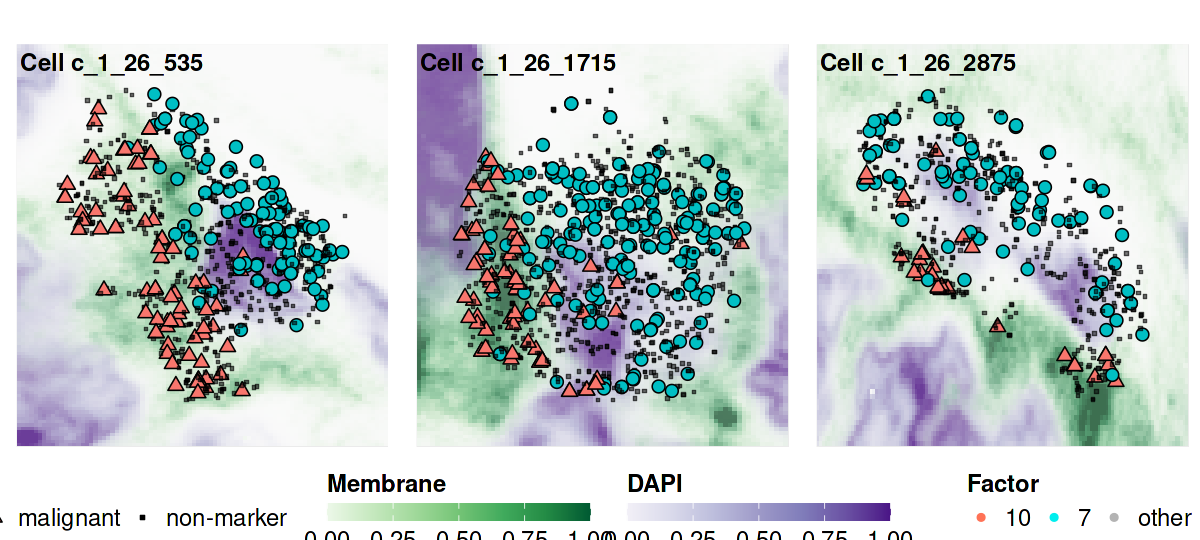

In [11]:
options(repr.plot.width=10, repr.plot.height=4.5)
fig2

In [12]:
pdf(OutputPath("nsclc_example_cells.pdf"), useDingbats=FALSE, width=10, height=4.5)
fig2
dev.off()


png 
  2

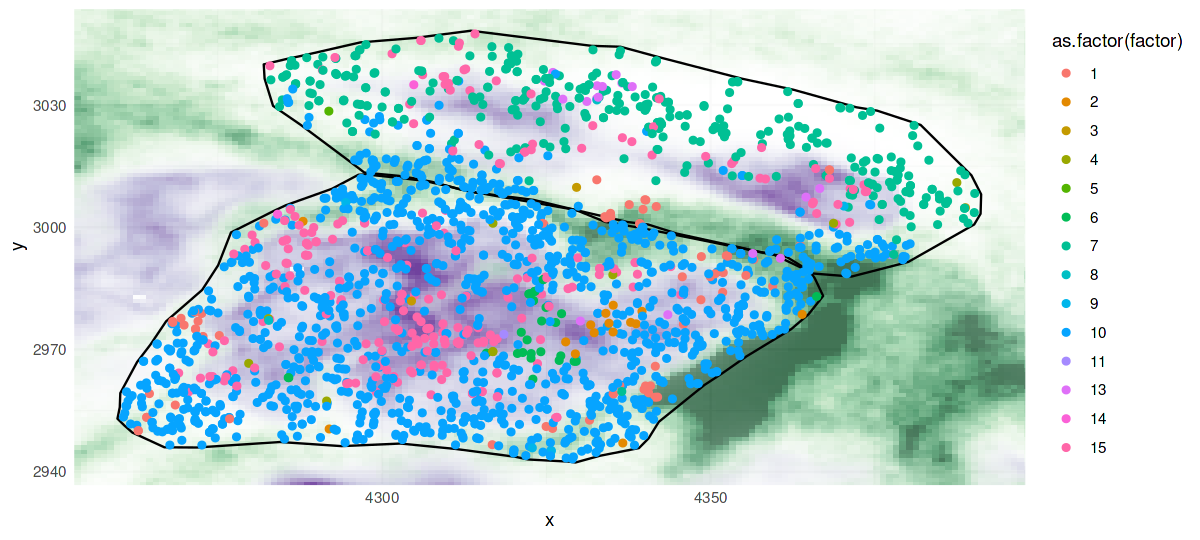

In [16]:
## plotting example cell pairs to explain membrane/bridge annotation
alpha_val <- 24
buffer <- 1

cells_include <- c('c_1_26_2875','c_1_26_2886')
df_cell <- df_for_memb[df_for_memb$cell%in%cells_include,]
# ndx_nudge <- which(duplicated(df_cell[,c('x','y')]))
df_tmp <- df_cell[,c('x','y','cell')]
ndx_keep <- which(!duplicated(df_tmp[,c('x','y')]))
df_tmp <- df_tmp[ndx_keep,]
# df_tmp[ndx_nudge,c('x','y')] <- df_tmp[ndx_nudge,c('x','y')] +.001
hull_data <- df_tmp %>%
  group_by(cell) %>%
  do({
    poly <- alpha_polygon(.$x, .$y, alpha_val = alpha_val, buffer = buffer)
    poly$cell <- unique(.$cell)
    poly
  }) %>%
  ungroup()

z.id <- 4
stains <- stains_colored_per_fov[['26']][[paste(z.id)]]
stains %<>% extractStainRegionAnnot(df_cell, expand=.15, inv.y.global=TRUE, inv.y.local=FALSE)

p <- ggplot(df_cell, aes(x = x, y = y, color = as.factor(factor))) +
  stains +
  geom_polygon(data = hull_data[hull_data$cell==cells_include[1],], aes(x = x, y = y),color='black',
               alpha = 0.001, show.legend = FALSE) +
  geom_polygon(data = hull_data[hull_data$cell==cells_include[2],], aes(x = x, y = y),color='black',
               alpha = 0.001, show.legend = FALSE) +
  geom_point() +
  theme_minimal()

p

In [17]:
pdf(OutputPath("nsclc_example_adj_cell.pdf"), useDingbats=FALSE, width=7, height=5)
rasterise(p, layers="Tile")
dev.off()

png 
  2